 The high-level idea is that the encoder could produce a representation of length equal to the original input sequence. Then, at decoding time, the decoder can (via some control mechanism) receive as input a context vector consisting of a weighted sum of the representations on the input at each time step. Intuitively, the weights determine the extent to which each step’s context “focuses” on each input token, and the key is to make this process for assigning the weights differentiable so that it can be learned along with all of the other neural network parameters.

In [1]:
import tensorflow as tf
from utils import util_functions as utils

2024-12-27 16:11:59.760809: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-27 16:11:59.760835: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-27 16:11:59.760839: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-27 16:11:59.760866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-27 16:11:59.760883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


scores: (batch_size, num_queries_per_sample, num_keys)
valid_lens: (batch_size, num_queries_per_sample)

In [2]:
def masked_softmax(X, valid_lens, value=0):
  """
  X: (batch_size, num_queries_per_sample, num_keys)
  valid_lens: (batch_size, ) OR (batch_size, num_queries_per_sample)
  """
  if valid_lens is None:
    return tf.nn.softmax(logits=X, axis=-1)
  
  shape = X.shape
  batch_size = shape[0]
  num_queries_per_sample = shape[1]
  num_keys = shape[2]

  X = tf.reshape(X, shape=(-1, num_keys)) 
  ## Shape: (batch_size * num_queries_per_sample, num_keys)
  if len(valid_lens.shape) == 1:
    valid_lens = tf.repeat(valid_lens, repeats=shape[1]) 
    ## Shape (batch_size * num_queries_per_sample, )
  else:
    valid_lens = tf.reshape(valid_lens, shape=-1)       
    ## Shape (batch_size * num_queries_per_sample, )

  mask = tf.range(0, num_keys)      ## Shape (num_keys, )
  mask = tf.expand_dims(mask, axis=0)     ## Shape (1, num_keys)
  mask = tf.tile(mask, multiples=[batch_size*num_queries_per_sample, 1])     
  ## Shape (batch_size * num_queries_per_sample, num_keys)

  valid_lens = tf.expand_dims(valid_lens, axis=1) 
  ## Shape (batch_size * num_queries_per_sample, 1)

  valid_lens = tf.tile(valid_lens, multiples=[1, num_keys])     
  ## Shape (batch_size * num_queries_per_sample, num_keys)

  masked_X = tf.where(mask < valid_lens, x=X, y=value)
  masked_X = tf.reshape(masked_X, shape=shape)
  return tf.nn.softmax(masked_X, axis=-1)

In [3]:
masked_softmax(tf.random.uniform(shape=(2, 2, 4)), tf.constant([2, 3]), value=-1e6)

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0.6842213 , 0.31577864, 0.        , 0.        ],
        [0.5368937 , 0.46310624, 0.        , 0.        ]],

       [[0.23578747, 0.5162821 , 0.24793042, 0.        ],
        [0.20890242, 0.38923627, 0.40186128, 0.        ]]], dtype=float32)>

In [4]:
class DotProductAttention(tf.keras.layers.Layer):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, queries, keys, values, valid_lens=None, **kwargs):
    """
    Queries: Decoder Input: (batch_size, num_queries_per_sample, dims)
    Keys: Encoder Hidden States: (batch_size, num_keys, dims)           ## (num_keys = num_steps)
    Values: Encoder Hidden States: (batch_size, num_keys, dims)         ## (num_keys = num_steps)
    Valid Lens: (batch_size, ) OR (batch_size, num_queries_per_sample)  
    """
    dims = queries.shape[-1]
    scores = tf.matmul(a=queries, b=keys, transpose_b=True)/tf.math.sqrt(x=tf.cast(dims, dtype=tf.float32))
    ## (batch_size, num_queries, num_keys)
    self.attention_weights = masked_softmax(X=scores, valid_lens=valid_lens)
    ## (batch_size, num_queries, num_keys)

    weights = self.dropout(self.attention_weights, **kwargs) 
    ## (batch_size, num_queries, num_keys)

    ## (batch_size, num_queries, dims)
    return tf.matmul(weights, values)

In [5]:
queries = tf.random.normal(shape=(2, 1, 2))
keys = tf.random.normal(shape=(2, 10, 2))
values = tf.random.normal(shape=(2, 10, 4))
valid_lens = tf.constant([2, 6])

attention = DotProductAttention(dropout=0.5)
attention(queries, keys, values, valid_lens, training=False).shape

TensorShape([2, 1, 4])

In [6]:
class AdditiveAttention(tf.keras.layers.Layer):
  def __init__(self, key_dims, query_dims, num_hiddens, dropout, **kwargs):
    super().__init__(**kwargs)
    self.dropout = tf.keras.layers.Dropout(dropout)
    self.W_k = tf.keras.layers.Dense(units=num_hiddens, use_bias=False)
    self.W_q = tf.keras.layers.Dense(units=num_hiddens, use_bias=False)
    self.w_v = tf.keras.layers.Dense(units=1, use_bias=False)

  def call(self, queries, keys, values, valid_lens=None, **kwargs):
    """
    Queries: Decoder Input: (batch_size, num_queries_per_sample, dims_1)
    Keys: Encoder Hidden States: (batch_size, num_keys, dims_1)           ## (num_keys = num_steps)
    Values: Encoder Hidden States: (batch_size, num_keys, dims)           ## (num_keys = num_steps)
    Valid Lens: (batch_size, ) OR (batch_size, num_queries_per_sample)  
    """

    queries = self.W_q(queries) # (batch_size, num_queries_per_sample, num_hiddens)
    keys = self.W_k(keys)       # (batch_size, num_keys, num_hiddens)

    features = tf.expand_dims(input=queries, axis=2) + tf.expand_dims(input=keys, axis=1)
               # (batch_size, num_queries_per_sample, 1, num_hiddens) 
               # (batch_size, 1, num_keys, num_hiddens)
               # Output: (batch_size, num_queries_per_sample, num_keys, num_hiddens)
    features = tf.nn.tanh(features)
    scores = tf.squeeze(self.w_v(features), axis=-1)
    ## (batch_size, num_queries, num_keys)
    
    self.attention_weights = masked_softmax(X=scores, valid_lens=valid_lens)
    ## (batch_size, num_queries, num_keys)

    weights = self.dropout(self.attention_weights, **kwargs) 
    ## (batch_size, num_queries, num_keys)

    ## (batch_size, num_queries, dims)
    return tf.matmul(weights, values)

In [7]:
queries = tf.random.normal(shape=(2, 1, 20))

attention = AdditiveAttention(key_dims=2, query_dims=20, num_hiddens=8,
                              dropout=0.1)
attention(queries, keys, values, valid_lens, training=False).shape

TensorShape([2, 1, 4])

In [8]:
class AttentionDecoder(utils.Decoder):
  """Base Attention Based Decoder Interface"""
  def __init__(self):
    super().__init__()

  @property
  def attention_weights(self):
    raise NotImplementedError

In [9]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers=2, dropout=0):
    super().__init__()
    self.attention = utils.AdditiveAttention(key_dims=num_hiddens, query_dims=num_hiddens, num_hiddens=num_hiddens, dropout=0)

    ## accepts (num_steps, batch_size) as input
    ## gives out (num_steps, batch_size, embed_size)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size)

    ## Accepts (num_steps, batch_size, embed_size)
    ## gives out (num_steps, batch_size, num_hiddens), [(batch_size, num_hiddens)]
    self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells([
      tf.keras.layers.GRUCell(num_hiddens, dropout=dropout) for _ in range(num_layers)
    ]), return_sequences=True, return_state=True)
    self.dense = tf.keras.layers.Dense(units=vocab_size)
    
  def init_state(self, enc_all_outputs, *args):
    """returns encoder outs"""
    return enc_all_outputs, *args
  
  def call(self, X, state):
    """
    X: shape (batch_size, num_steps)
    state: from encoder encoder outputs
    Output: (num_steps, batch_size, vocab_size)
    """
    num_steps = X.shape[1]
    decoder_inputs = self.embedding(tf.transpose(X))
    encoder_outputs, hidden_state, valid_lens = state
    
    context_vector = encoder_outputs[-1] 
    #(batch_size, num_hiddens)

    context_vector = tf.expand_dims(input=context_vector, axis=0) 
    # (1, batch_size, num_hiddens)
    
    context_vector = tf.tile(input=context_vector, multiples=[num_steps, 1, 1]) 
    # (num_steps, batch_size, num_hiddens)

    decoder_inputs = tf.concat([decoder_inputs, context_vector], axis=-1)

    decoder_outputs, hidden_state = self.rnn(X=decoder_inputs, state=hidden_state)  
    # (num_steps, batch_size, num_hiddens)
    
    outputs = self.dense(decoder_outputs) 
    # (num_steps, batch_size, vocab_size)

    outputs = tf.transpose(outputs, perm=[1, 0, 2]) 
    # (batch_size, num_steps, vocab_size)

    return outputs, [encoder_outputs, hidden_state]

## Multi Head Attention
Queries: (batch_size, num_queries_per_sample, query_dims)
Keys: (batch_size, num_steps, key_dims)
Values: (batch_size, num_steps, value_dims)


In [10]:
class MultiHeadAttention(utils.Module):
  def  __init__(self, key_dims, query_dims, value_dims, num_hiddens, num_heads, dropout, bias=False, **kwargs):
    super().__init__()
    self.num_heads = num_heads
    self.save_hyperparameters()
    self.attention = utils.DotProductAttention(dropout=dropout)
    self.W_q = tf.keras.layers.Dense(units=num_hiddens, use_bias=bias)
    self.W_k = tf.keras.layers.Dense(units=num_hiddens, use_bias=bias)
    self.W_v = tf.keras.layers.Dense(units=num_hiddens, use_bias=bias)
    self.W_o = tf.keras.layers.Dense(units=num_hiddens, use_bias=bias)    

  def call(self, queries, keys, values, valid_lens, **kwargs):
    queries = self.W_q(queries) ## (batch_size, num_queries_per_sample, num_hiddens)
    keys = self.W_k(keys)       ## (batch_size, num_keys, num_hiddens)
    values = self.W_v(values)   ## (batch_size, num_values, num_hiddens)

    batch_size = queries.shape[0]
    last_dims = self.num_hiddens // self.num_heads

    ## Redo
    queries = self.transpose(queries)
    keys = self.transpose(keys)
    values =  self.transpose(values)

    if valid_lens is not None:
      valid_lens = tf.repeat(valid_lens, repeats=self.num_heads, axis=0)

    output = self.attention(queries, keys, values, valid_lens)
    ## (batch_size * num_heads, num_queries_per_sample, last_dims)

    output = self.reverse_transpose(output)
    return self.W_o(output)
  
  def transpose(self, X):
    ## X: (batch_size, num_queries/keys/values, num_hiddens)
    batch_size, num_qkv, num_hiddens = X.shape
    
    X = tf.reshape(X, shape=(batch_size, num_qkv, self.num_heads, -1))
    ## (batch_size, num_queries/keys/values, num_heads, num_hiddens//num_heads)
    
    X = tf.transpose(X, perm=[0, 2, 1, 3])
    ## (batch_size, num_heads, num_queries/keys/values, num_hiddens//num_heads)

    X = tf.reshape(X, shape=(-1, num_qkv, num_hiddens // self.num_heads))
    ## (batch_size * num_heads, num_queries/keys/values, num_hiddens//num_heads)

    return X
  
  def reverse_transpose(self, X):
    ## X: (batch_size*num_heads, num_queries/keys/values, num_hiddens//num_heads)
    batch_size_times_num_heads, num_qkv, num_hiddens_per_num_heads = X.shape
    
    batch_size = batch_size_times_num_heads // self.num_heads
    X  = tf.reshape(X, shape=(batch_size, self.num_heads, num_qkv, num_hiddens_per_num_heads))
    
    X = tf.transpose(X, perm=[0, 2, 1, 3])
    ## (batch_size, num_queries/keys/values, num_heads, num_hiddens//num_heads)

    X = tf.reshape(X, shape=(batch_size, num_qkv, self.num_hiddens))
    ## (batch_size, num_queries/keys/values, num_hiddens)

    return X

In [11]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(key_dims=num_hiddens, query_dims=num_hiddens, value_dims=num_hiddens,num_hiddens=num_hiddens, num_heads=num_heads, dropout=0.5)

batch_size = 2
num_queries_per_sample = 4
num_keys = 6
num_values = 6
valid_lens = tf.constant([3, 2])
queries = tf.ones(shape=(batch_size, num_queries_per_sample, num_hiddens))
keys = tf.ones(shape=(batch_size, num_keys, num_hiddens))
attention(queries=queries, keys=keys, values=keys, valid_lens=valid_lens).shape

TensorShape([2, 4, 100])

Positional Encoding

In [12]:
import numpy as np

class PositionalEncoding(tf.keras.layers.Layer):
  """Positional Encoding"""
  def __init__(self, num_hiddens, dropout, max_len=1000):
    super().__init__()
    self.dropout = tf.keras.layers.Dropout(dropout)

    self.P = np.zeros(shape=(1, max_len, num_hiddens))
    dr = np.power(10000, np.arange(0, num_hiddens, 2, dtype=np.float32) / num_hiddens)
    nr = np.arange(max_len, dtype=np.float32).reshape(-1, 1)
    X =  nr / dr

    self.P[:, :, 0::2] = np.sin(X)
    self.P[:, :, 1::2] = np.cos(X)

  def call(self, X, **kwargs):
    X = X + self.P[:, :X.shape[1], :]
    return self.dropout(X, **kwargs)

In [13]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(num_hiddens=encoding_dim, dropout=0)
X = pos_encoding(tf.zeros((1, num_steps, encoding_dim)), training=False)
P = pos_encoding.P[:, :X.shape[1], :]

In [14]:
P.shape

(1, 60, 32)

In [15]:
import tensorflow as tf
X = tf.ones((2, 100, 24))
valid_lens = tf.constant([3, 2])
norm_shape = [i for i in range(len(X.shape))][1:]

In [16]:
norm_shape

[1, 2]

### AddNorm Layer

In [17]:
class AddNorm(tf.keras.layers.Layer):
  """Residual Connection followed by layer normalization
     Normalization Shape: Shape of X excluding the first dimension (batch_size)
  """
  def __init__(self, norm_shape, dropout):
    super().__init__()
    self.dropout = tf.keras.layers.Dropout(dropout)
    self.ln = tf.keras.layers.LayerNormalization(axis=norm_shape)

  def call(self, X, Y, **kwargs):
    return self.ln(self.dropout(Y, **kwargs) + X)

In [18]:
add_norm = AddNorm(norm_shape=[1, 2], dropout=0.5)
shape = (2, 3, 4)
add_norm(tf.ones(shape=shape), tf.ones(shape=shape), training=False).shape

TensorShape([2, 3, 4])

## PositionWise FFN

In [19]:
class PositionWiseFFN(tf.keras.layers.Layer):
  def __init__(self, ffn_num_hiddens, ffn_num_outputs):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(units=ffn_num_hiddens)
    self.relu = tf.keras.layers.ReLU()
    self.dense2 = tf.keras.layers.Dense(units=ffn_num_outputs)

  def call(self, X):
    return self.dense2(self.relu(self.dense1(X)))

In [20]:
ffn = PositionWiseFFN(ffn_num_hiddens=4, ffn_num_outputs=8)
ffn(tf.ones((2, 3, 4))).shape

TensorShape([2, 3, 8])

## Transformer Architecture

In [21]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
  """The Transformer Encoder Block"""
  def __init__(self, key_dims, query_dims, value_dims, num_hiddens, norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False):
    super().__init__()
    self.attention = utils.MultiHeadAttention(key_dims=key_dims, query_dims=query_dims, value_dims=value_dims, num_hiddens=num_hiddens,num_heads=num_heads, dropout=dropout, bias=bias)
    ## Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.addnorm1 = AddNorm(norm_shape=norm_shape, dropout=dropout)
    ## Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.ffn = PositionWiseFFN(ffn_num_hiddens=ffn_num_hiddens, ffn_num_outputs=num_hiddens)
    # Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.addnorm2 = AddNorm(norm_shape=norm_shape, dropout=dropout)
    ## Output: (batch_size, num_steps, num_hiddens)

  def call(self, X, valid_lens, **kwargs):
    Y = self.attention(X, X, X, valid_lens, **kwargs)
    Y = self.addnorm1(X, Y, **kwargs)

    return self.addnorm2(Y, self.ffn(Y), **kwargs)

In [22]:
batch_size = 2
num_steps = 100
num_hiddens = 24
valid_lens = tf.constant([3, 2])
X = tf.ones(shape=(batch_size, num_steps, num_hiddens))
norm_shape = [i for i in range(1, len(X.shape))][1:] ## Normlaize only along last axis (skip(batch_size, num_steps))


In [23]:
norm_shape

[2]

In [24]:
encoder_blk = TransformerEncoderBlock(key_dims=num_hiddens, query_dims=num_hiddens, value_dims=num_hiddens, num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=2*num_hiddens, num_heads=8, dropout=0.5)
encoder_blk(X, valid_lens, training=False).shape

TensorShape([2, 100, 24])

In [25]:
class TransformerEncoder(utils.Encoder):
  """The Transformer Encoder"""
  def __init__(self, vocab_size, num_blks, key_dims, query_dims, value_dims, num_hiddens, norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens=num_hiddens, dropout=dropout)
    self.blks = [TransformerEncoderBlock(key_dims=key_dims, query_dims=query_dims, value_dims=value_dims, num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, dropout=0.5) for _ in range(num_blks)]

  def call(self, X, valid_lens, **kwargs):
    X = self.embedding(X) * tf.math.sqrt(x=tf.cast(self.num_hiddens, dtype=tf.float32))
    X = self.pos_encoding(X, **kwargs)
    self.attention_weights = [None] * len(self.blks)
    for i, blk in enumerate(self.blks):
      X = blk(X, valid_lens, **kwargs)
      #self.attention_weights[i] = blk.attention.attention.attention_weights

    return X


In [26]:
encoder = TransformerEncoder(vocab_size=200, num_blks=2, key_dims=num_hiddens, query_dims=num_hiddens, value_dims=num_hiddens,num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=2*num_hiddens, num_heads=4, dropout=0.5)

encoder(tf.ones(shape=(2, 100)), valid_lens, training=False).shape

TensorShape([2, 100, 24])

In [27]:
encoder.blks[0].attention.attention.attention_weights

<tf.Tensor: shape=(8, 100, 100), dtype=float32, numpy=
array([[[0.00267568, 0.00217749, 0.00232905, ..., 0.01023523,
         0.01023523, 0.01023523],
        [0.00250851, 0.00208195, 0.00228748, ..., 0.01023837,
         0.01023837, 0.01023837],
        [0.00250017, 0.00207468, 0.00230476, ..., 0.01023836,
         0.01023836, 0.01023836],
        ...,
        [0.00415729, 0.00379688, 0.00402691, ..., 0.01018576,
         0.01018576, 0.01018576],
        [0.00545227, 0.00492274, 0.00488301, ..., 0.01015198,
         0.01015198, 0.01015198],
        [0.00694258, 0.00624743, 0.00585644, ..., 0.01011292,
         0.01011292, 0.01011292]],

       [[0.00837723, 0.00843976, 0.00760576, ..., 0.0100575 ,
         0.0100575 , 0.0100575 ],
        [0.00613684, 0.00636679, 0.00591561, ..., 0.01011939,
         0.01011939, 0.01011939],
        [0.00495287, 0.00513683, 0.0048775 , ..., 0.01015498,
         0.01015498, 0.01015498],
        ...,
        [0.00969766, 0.00972186, 0.0078136 , ..., 0.0

In [28]:
class TransformerDecoderBlock(tf.keras.layers.Layer):
  ## ith block in the transformer decoder
  def __init__(self, key_dims, query_dims, value_dims, num_hiddens, norm_shape, ffn_num_hiddens, num_heads, dropout, i, bias=False):
    super().__init__()
    self.i = i
    self.attention1 = utils.MultiHeadAttention(key_dims=key_dims, query_dims=query_dims, value_dims=value_dims, num_hiddens=num_hiddens,num_heads=num_heads, dropout=dropout, bias=bias)
    ## Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.addnorm1 = AddNorm(norm_shape=norm_shape, dropout=dropout)
    ## Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.attention2 = utils.MultiHeadAttention(key_dims=key_dims, query_dims=query_dims, value_dims=value_dims, num_hiddens=num_hiddens,num_heads=num_heads, dropout=dropout, bias=bias)
    ## Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.addnorm2 = AddNorm(norm_shape=norm_shape, dropout=dropout)
    ## Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.ffn = PositionWiseFFN(ffn_num_hiddens=ffn_num_hiddens, ffn_num_outputs=num_hiddens)
    # Input: (batch_size, num_steps, num_hiddens)
    ## Output: (batch_size, num_steps, num_hiddens)

    self.addnorm3 = AddNorm(norm_shape=norm_shape, dropout=dropout)

  def call(self, X, state, **kwargs):
    enc_outputs, enc_valid_lens = state[0], state[1]
    
    if state[2][self.i] is None:
      key_values = X
    else:
      key_values = tf.concat((state[2][self.i], X), axis=1) ## To Revisit
    
    state[2][self.i] = key_values
    if kwargs["training"]:
      batch_size, num_steps, _ = X.shape
      dec_valid_lens = tf.range(1, num_steps+1)
      dec_valid_lens = tf.reshape(dec_valid_lens, shape=(-1, num_steps))
      dec_valid_lens = tf.repeat(dec_valid_lens, repeats=batch_size, axis=0)
    else:
      dec_valid_lens = None
    
    ## Self Attention Masked
    X2 = self.attention1(X, key_values, key_values, dec_valid_lens, **kwargs)
    Y = self.addnorm1(X, X2, **kwargs)

    ## Attention with Encoder Outputs
    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, **kwargs)
    Z = self.addnorm2(Y, Y2, **kwargs)

    return self.addnorm3(Z, self.ffn(Z), **kwargs), state

In [29]:
decoder_blk = TransformerDecoderBlock(key_dims=num_hiddens, query_dims=num_hiddens, value_dims=num_hiddens, num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=2*num_hiddens, num_heads=4, dropout=0.5, i=0)
X = tf.ones(shape=(2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [X]]
decoder_blk(X, state, training=False)[0].shape

TensorShape([2, 100, 24])

In [36]:
class TransformerDecoder(utils.AttentionDecoder):
  def __init__(self, vocab_size, num_blks, key_dims, query_dims, value_dims, num_hiddens, norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.num_blks = num_blks
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=num_hiddens)
    self.pos_encoding = PositionalEncoding(num_hiddens=num_hiddens, dropout=dropout)
    self.blks = [TransformerDecoderBlock(key_dims=key_dims, query_dims=query_dims, value_dims=value_dims, num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, dropout=0.5, i=i) for i in range(num_blks)]
    self.dense = tf.keras.layers.Dense(units=vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens):
    return [enc_outputs, enc_valid_lens, [None]*self.num_blks]
  
  def call(self, X, state, **kwargs):
    X = self.embedding(X) * tf.math.sqrt(x=tf.cast(self.num_hiddens, dtype=tf.float32))
    X = self.pos_encoding(X, **kwargs)

    self._attention_weights = [[None]*len(self.blks) for _ in range(2)]
    for i, blk in enumerate(self.blks):
      X, state = blk(X, state, **kwargs)
      self._attention_weights[0][i] = blk.attention1.attention.attention_weights
      self._attention_weights[1][i] = blk.attention1.attention.attention_weights

    return self.dense(X), state
  
  @property
  def attention_weights(self):
    return self._attention_weights

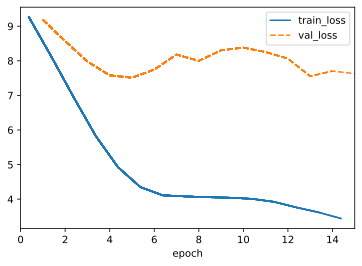

In [37]:
with tf.device('CPU: 0'):
  data = utils.MTFraEng(batch_size=128)
  src_examples, target_examples = data._get_src_tgt_arrays()
  data.build(src_examples, target_examples)

  num_hiddens, num_blks, dropout = 256, 2, 0.2
  ffn_num_hiddens, num_heads = 64, 4
  key_size, query_size, value_size = 256, 256, 256

  norm_shape = [2]
  encoder = TransformerEncoder(vocab_size=len(data.src_vocab), num_blks=num_blks, key_dims=key_size, query_dims=query_size, value_dims=value_size, num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, dropout=dropout)
  decoder = TransformerDecoder(vocab_size=len(data.tgt_vocab), num_blks=num_blks, key_dims=key_size, query_dims=query_size, value_dims=value_size, num_hiddens=num_hiddens, norm_shape=norm_shape, ffn_num_hiddens=ffn_num_hiddens, num_heads=num_heads, dropout=dropout)
  model = utils.Seq2SeqEncoderDecoder(encoder=encoder, decoder=decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)

  trainer = utils.Trainer(max_epochs=15, gradient_clip_val=1)
  trainer.fit(model, data)